### 필요한 라이브러리 import

In [1]:
import warnings
warnings.filterwarnings("ignore")

import os
from os.path import join

import pandas as pd
import numpy as np

import missingno as msno

import matplotlib.pyplot as plt
%matplotlib inline
%config InlineBackend.figure_format = 'retina'
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error

from xgboost import XGBRegressor
from lightgbm import LGBMRegressor
from sklearn.ensemble import GradientBoostingRegressor, RandomForestRegressor

from sklearn.model_selection import GridSearchCV

import scipy as sp

### 데이터 로드

1. **ID** : 집을 구분하는 번호
2. **date** : 집을 구매한 날짜
3. **price** : 타겟 변수인 집의 가격
4. **bedrooms** : 침실의 수
5. **bathrooms** : 침실당 화장실 개수
6. **sqft_living** : 주거 공간의 평방 피트
7. **sqft_lot** : 부지의 평방 피트
8. **floors** : 집의 층수
9. **waterfront** : 집의 전방에 강이 흐르는지 유무 (a.k.a. 리버뷰)
10. **view** : 집이 얼마나 좋아 보이는지의 정도
11. **condition** : 집의 전반적인 상태
12. **grade** : King County grading 시스템 기준으로 매긴 집의 등급
13. **sqft_above** : 지하실을 제외한 평방 피트
14. **sqft_basement** : 지하실의 평방 피트
15. **yr_built** : 집을 지은 년도
16. **yr_renovated** : 집을 재건축한 년도
17. **zipcode** : 우편번호
18. **lat** : 위도
19. **long** : 경도
20. **sqft_living15** : 2015년 기준 주거 공간의 평방 피트(집을 재건축했다면, 변화가 있을 수 있음)
21. **sqft_lot15** : 2015년 기준 부지의 평방 피트(집을 재건축했다면, 변화가 있을 수 있음)

In [2]:
data_dir = os.getenv('HOME')+'/aiffel/kaggle_kakr_housing/data'

train_data_path = join(data_dir, 'train.csv')
sub_data_path = join(data_dir, 'test.csv')

data = pd.read_csv(train_data_path)
sub = pd.read_csv(sub_data_path)
print(f'train data dim : {data.shape}')
print(f'sub data dim : {sub.shape}')

train data dim : (15035, 21)
sub data dim : (6468, 20)


데이터에서 라벨 제거

In [3]:
y = data['price']
del data['price']

전체 데이터를 탐색하기 위해 합치는 과정   
학습 시 학습 데이터와 테스트 데이터를 다시 분리하기 위해 train_len 생성

In [4]:
train_len = len(data)
data = pd.concat((data, sub), axis=0)

In [5]:
data

,id,date,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,view,condition,grade,sqft_above,sqft_basement,yr_built,yr_renovated,zipcode,lat,long,sqft_living15,sqft_lot15
0,0,20141013T000000,3,1.00,1180,5650,1.0,0,0,3,7,1180,0,1955,0,98178,47.5112,-122.257,1340,5650
1,1,20150225T000000,2,1.00,770,10000,1.0,0,0,3,6,770,0,1933,0,98028,47.7379,-122.233,2720,8062
2,2,20150218T000000,3,2.00,1680,8080,1.0,0,0,3,8,1680,0,1987,0,98074,47.6168,-122.045,1800,7503
3,3,20140627T000000,3,2.25,1715,6819,2.0,0,0,3,7,1715,0,1995,0,98003,47.3097,-122.327,2238,6819
4,4,20150115T000000,3,1.50,1060,9711,1.0,0,0,3,7,1060,0,1963,0,98198,47.4095,-122.315,1650,9711
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
6463,21498,20140626T000000,3,1.75,1500,11968,1.0,0,0,3,6,1500,0,2014,0,98010,47.3095,-122.002,1320,11303
6464,21499,20150126T000000,3,2.00,1490,1126,3.0,0,0,3,8,1490,0,2014,0,98144,47.5699,-122.288,1400,1230
6465,21500,20150219T000000,3,2.50,1310,1294,2.0,0,0,3,8,1180,130,2008,0,98116,47.5773,-122.409,1330,1265
6466,21501,20140623T000000,2,0.75,1020,1350,2.0,0,0,3,7,1020,0,2009,0,98144,47.5944,-122.299,1020,2007


### 데이터 탐색 및 전처리

결측치 확인

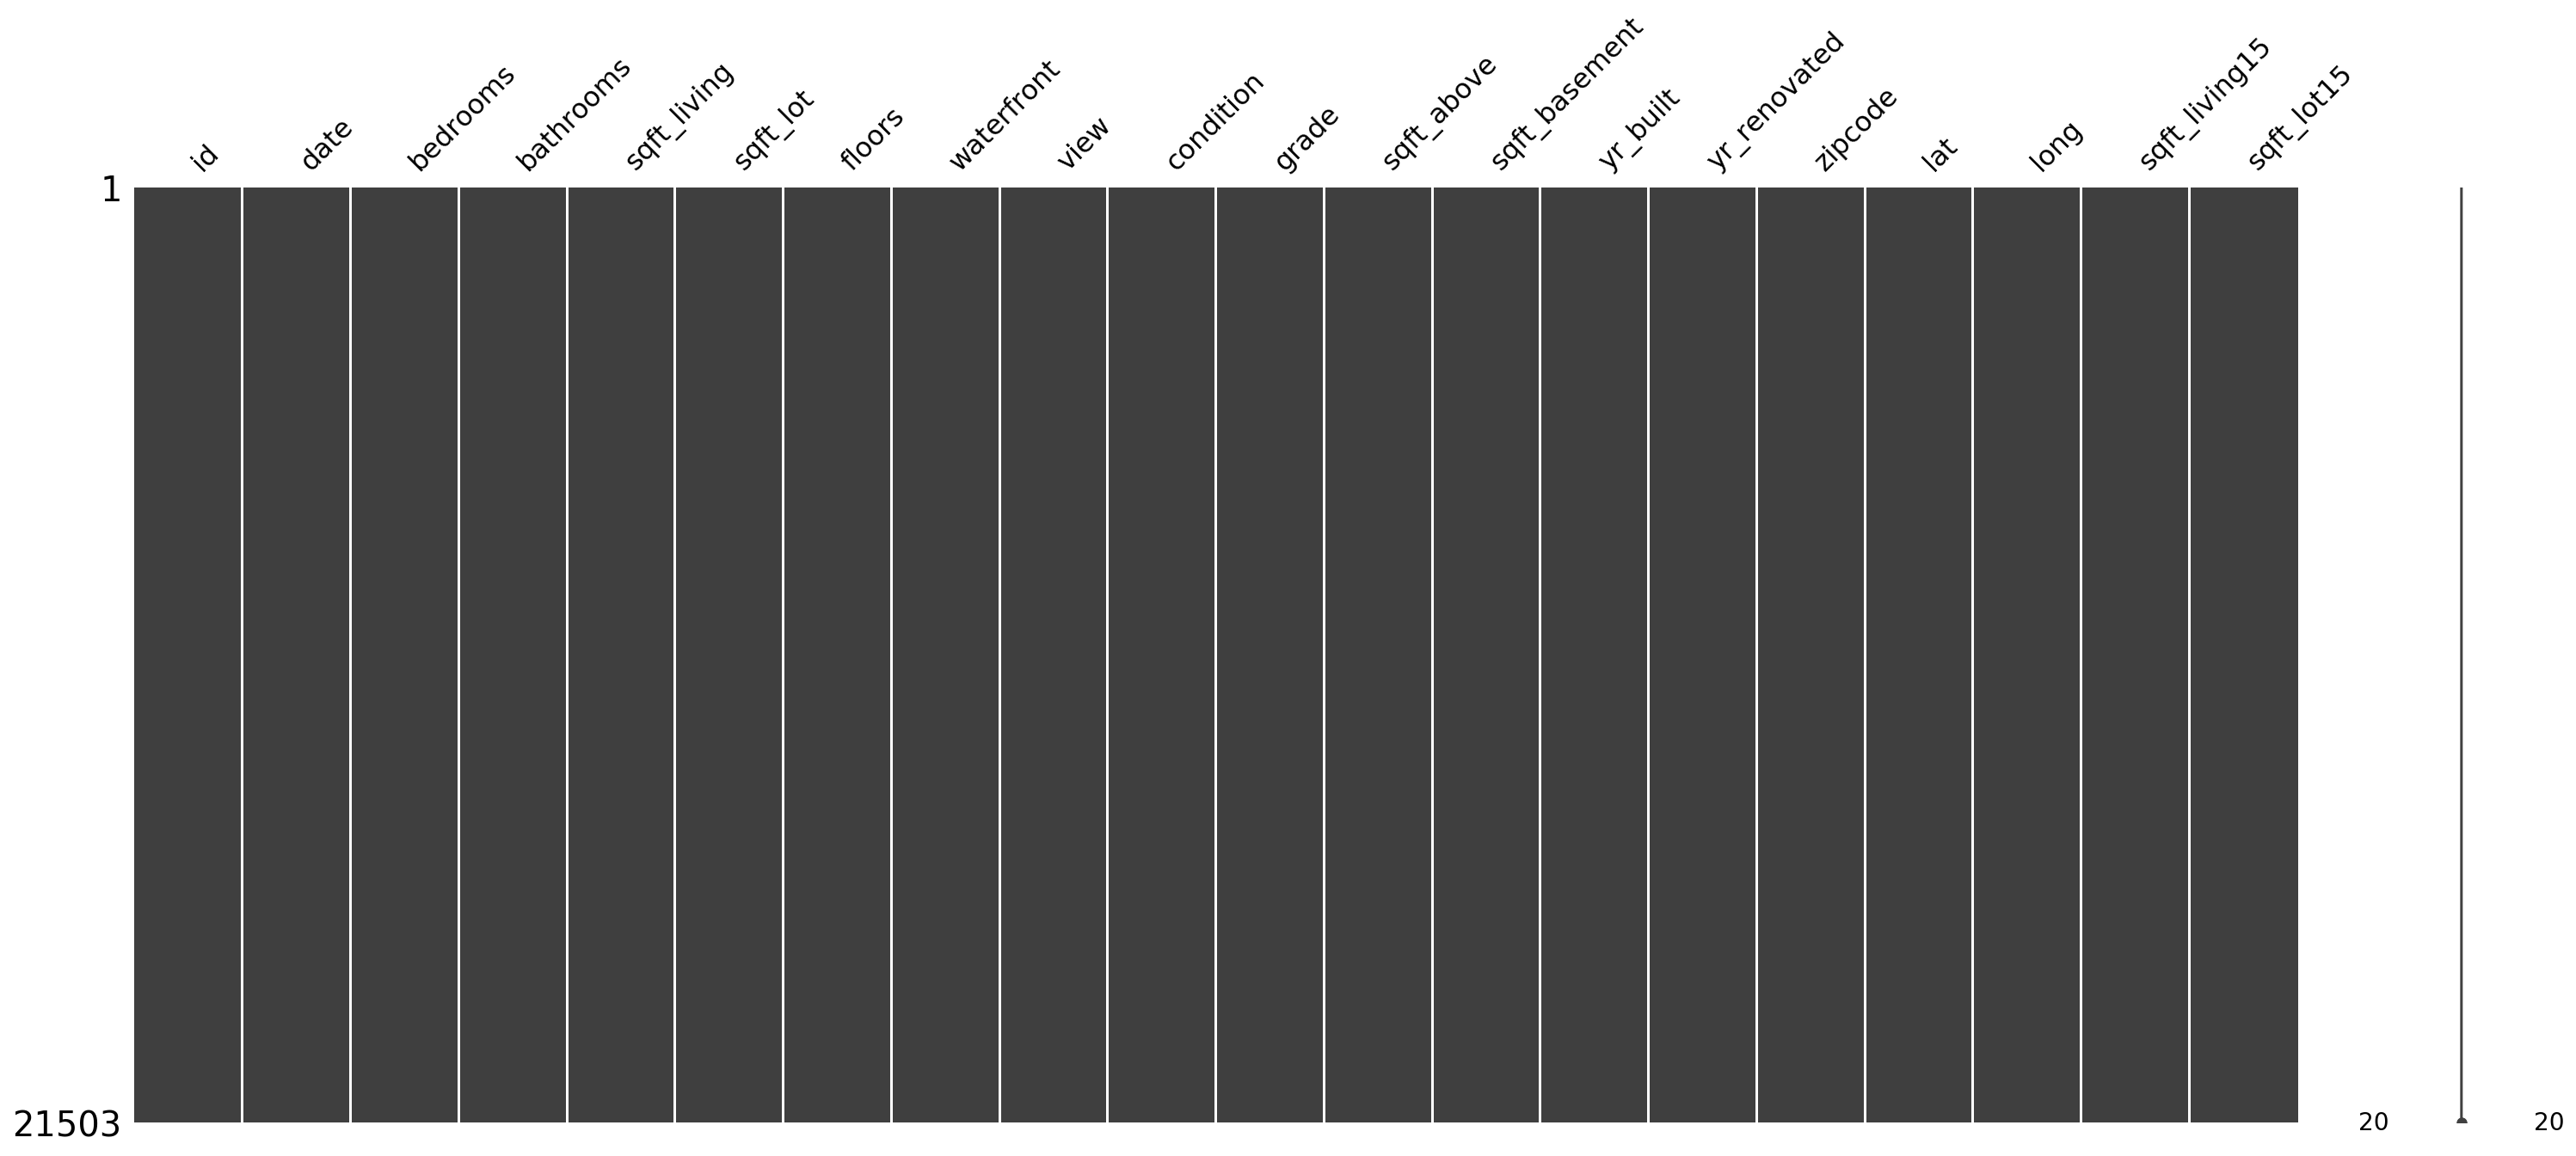

In [6]:
msno.matrix(data)

In [7]:
for c in data.columns:
    print(f'{c} : {len(data.loc[pd.isnull(data[c]), c].values)}')

id : 0
date : 0
bedrooms : 0
bathrooms : 0
sqft_living : 0
sqft_lot : 0
floors : 0
waterfront : 0
view : 0
condition : 0
grade : 0
sqft_above : 0
sqft_basement : 0
yr_built : 0
yr_renovated : 0
zipcode : 0
lat : 0
long : 0
sqft_living15 : 0
sqft_lot15 : 0


불필요한 id 컬럼 정리   
테스트 데이터에 대한 id는 제출 시 필요하므로 sub_id에 저장.

In [8]:
sub_id = data['id'][train_len:]
data = data.drop('id', axis=1)

date 컬럼을 연,월만 포함하게 정리

In [9]:
data['date'] = data['date'].apply(lambda x : str(x[:6]))

In [10]:
data

,date,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,view,condition,grade,sqft_above,sqft_basement,yr_built,yr_renovated,zipcode,lat,long,sqft_living15,sqft_lot15
0,201410,3,1.00,1180,5650,1.0,0,0,3,7,1180,0,1955,0,98178,47.5112,-122.257,1340,5650
1,201502,2,1.00,770,10000,1.0,0,0,3,6,770,0,1933,0,98028,47.7379,-122.233,2720,8062
2,201502,3,2.00,1680,8080,1.0,0,0,3,8,1680,0,1987,0,98074,47.6168,-122.045,1800,7503
3,201406,3,2.25,1715,6819,2.0,0,0,3,7,1715,0,1995,0,98003,47.3097,-122.327,2238,6819
4,201501,3,1.50,1060,9711,1.0,0,0,3,7,1060,0,1963,0,98198,47.4095,-122.315,1650,9711
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
6463,201406,3,1.75,1500,11968,1.0,0,0,3,6,1500,0,2014,0,98010,47.3095,-122.002,1320,11303
6464,201501,3,2.00,1490,1126,3.0,0,0,3,8,1490,0,2014,0,98144,47.5699,-122.288,1400,1230
6465,201502,3,2.50,1310,1294,2.0,0,0,3,8,1180,130,2008,0,98116,47.5773,-122.409,1330,1265
6466,201406,2,0.75,1020,1350,2.0,0,0,3,7,1020,0,2009,0,98144,47.5944,-122.299,1020,2007


각 컬럼 값들의 분포 확인

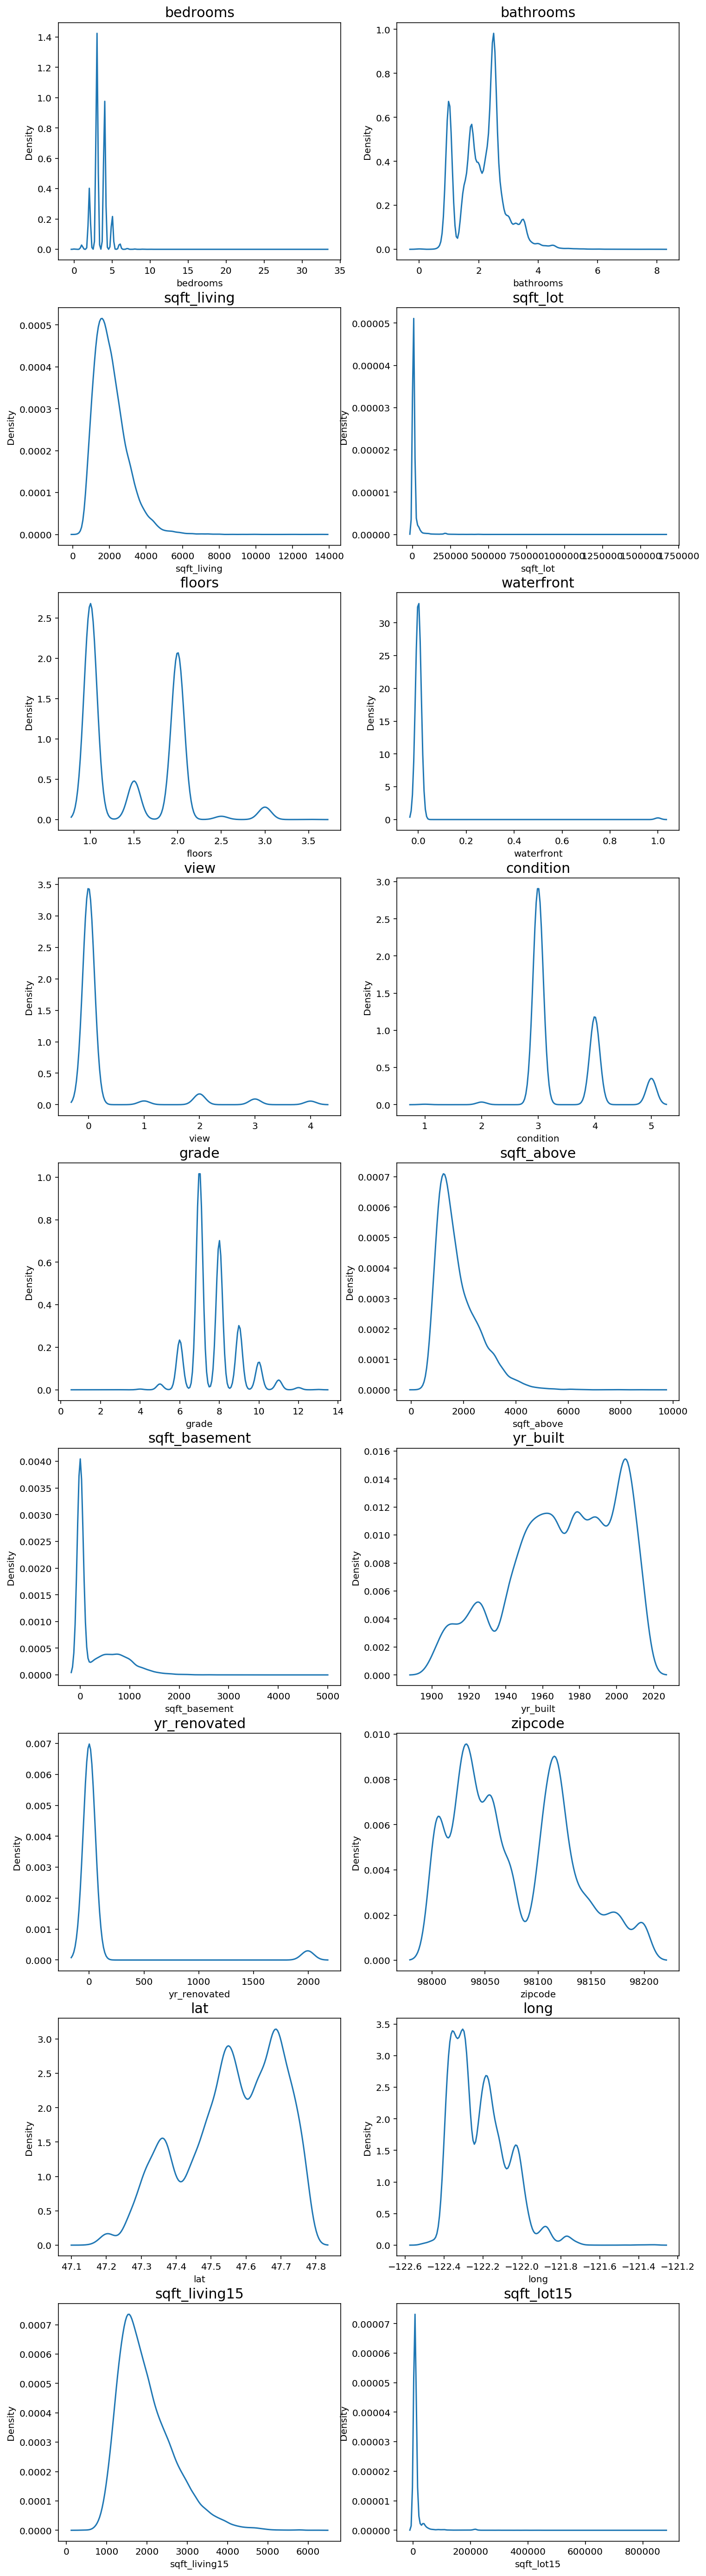

In [11]:
fig, ax = plt.subplots(9, 2, figsize=(12, 50)) 

count = 1
columns = data.columns
for row in range(9):
    for col in range(2):
        sns.kdeplot(data[columns[count]], ax=ax[row][col])
        ax[row][col].set_title(columns[count], fontsize=15)
        count += 1
        if count == 19 :
            break

한 쪽으로 치우친 특정 컬럼들을 정규분포에 가깝게 변환

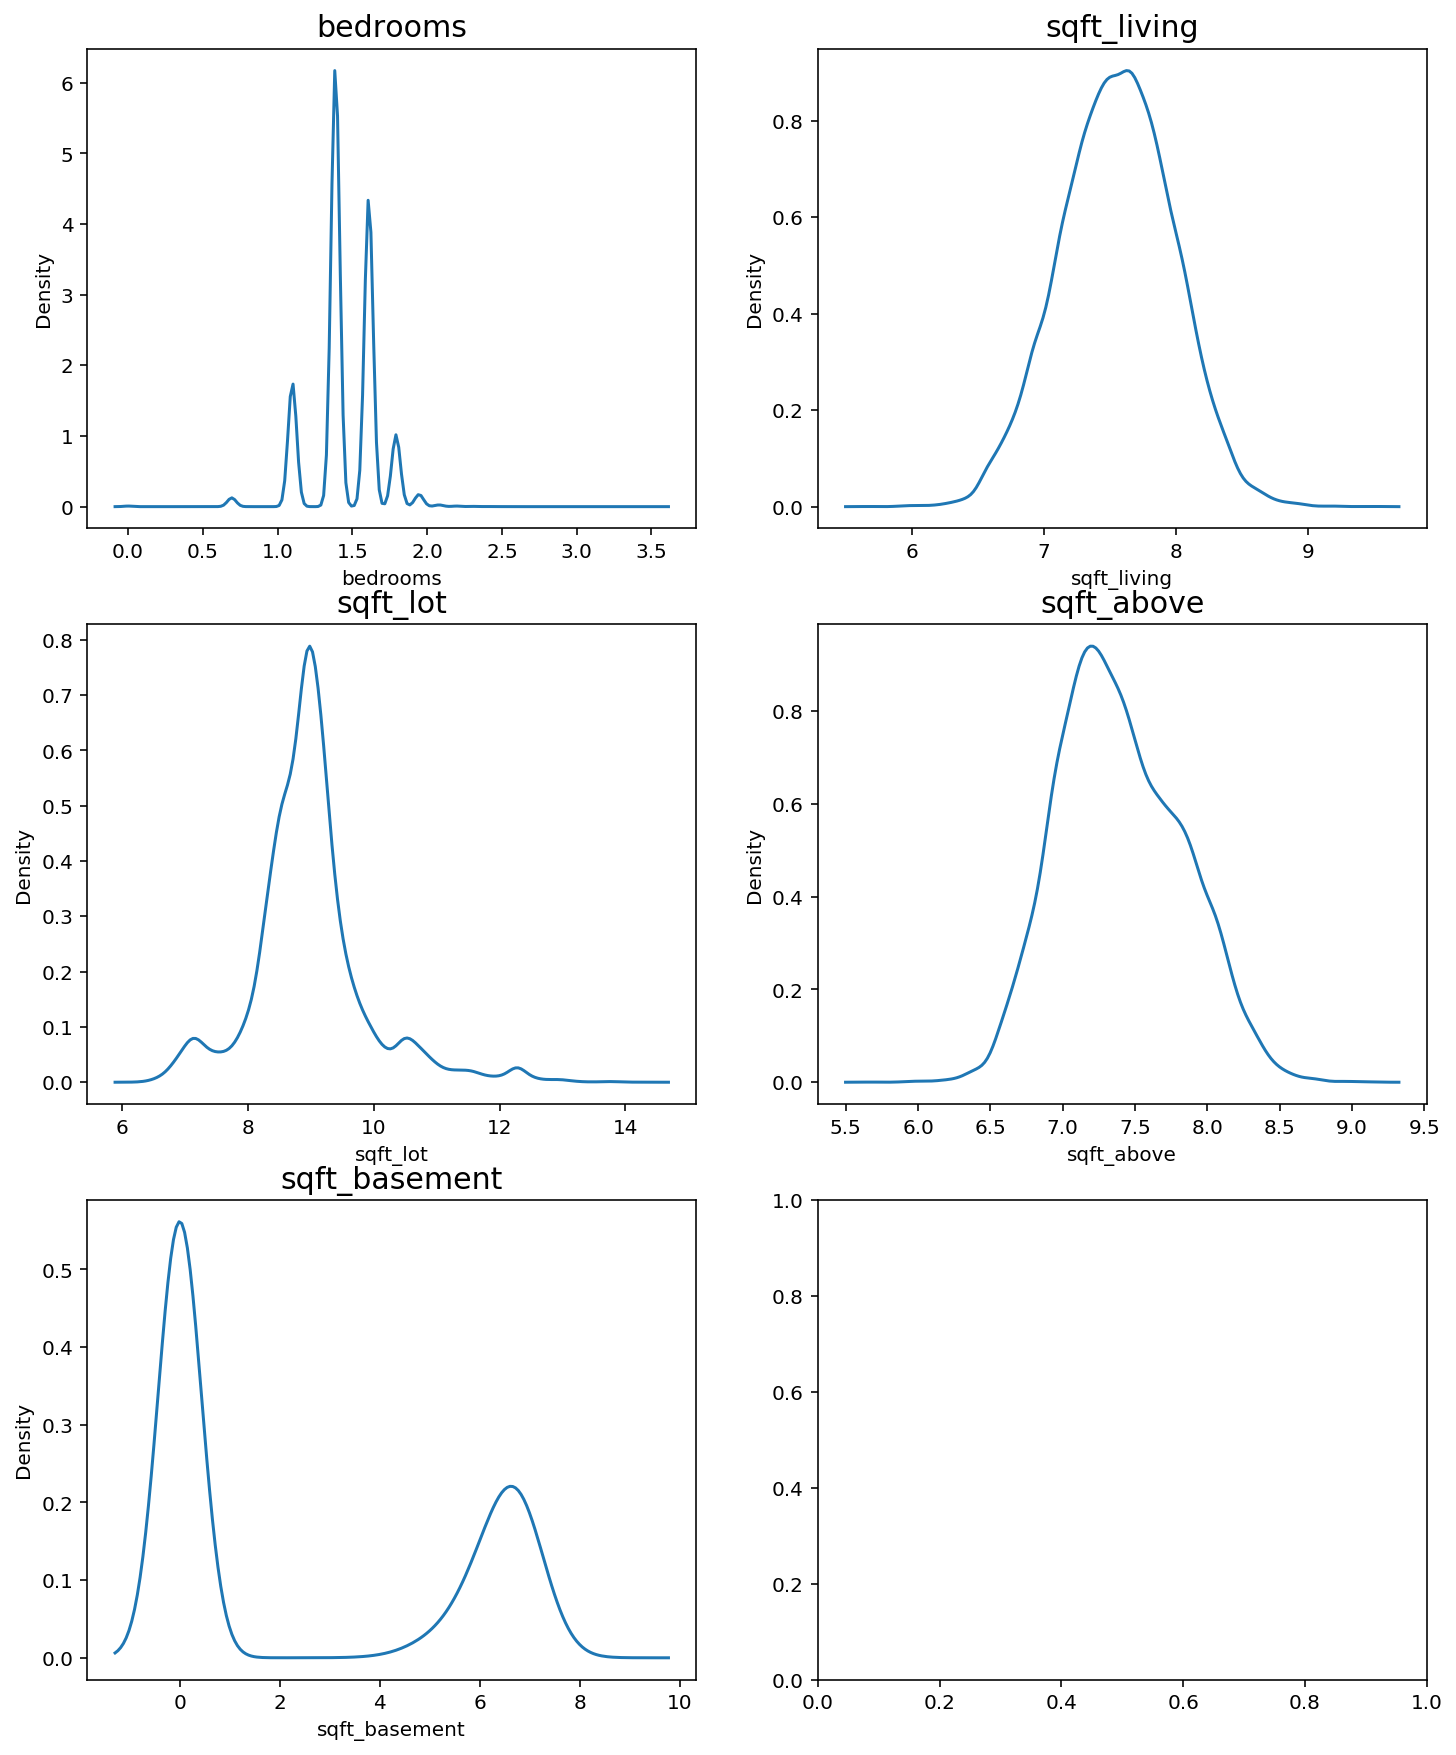

In [12]:
skew_columns = ['bedrooms', 'sqft_living', 'sqft_lot', 'sqft_above', 'sqft_basement']

for c in skew_columns:
    data[c] = np.log1p(data[c].values)

fig, ax = plt.subplots(3, 2, figsize=(12, 15))
count = 0
for row in range(3):
    for col in range(2):
        if count == 5:
            break
        sns.kdeplot(data[skew_columns[count]], ax=ax[row][col])
        ax[row][col].set_title(skew_columns[count], fontsize=15)
        count += 1

타겟(price) 분포 확인

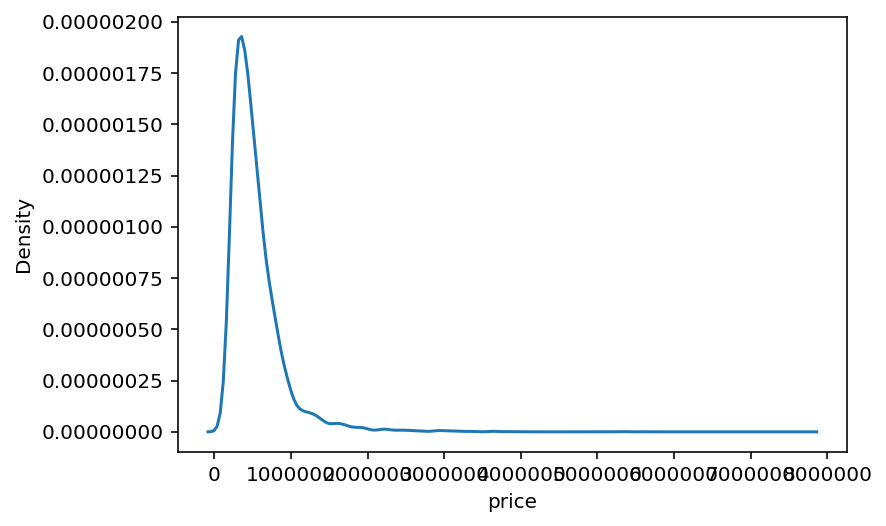

In [13]:
sns.kdeplot(y)
plt.show()

타겟 분포 정규분포화

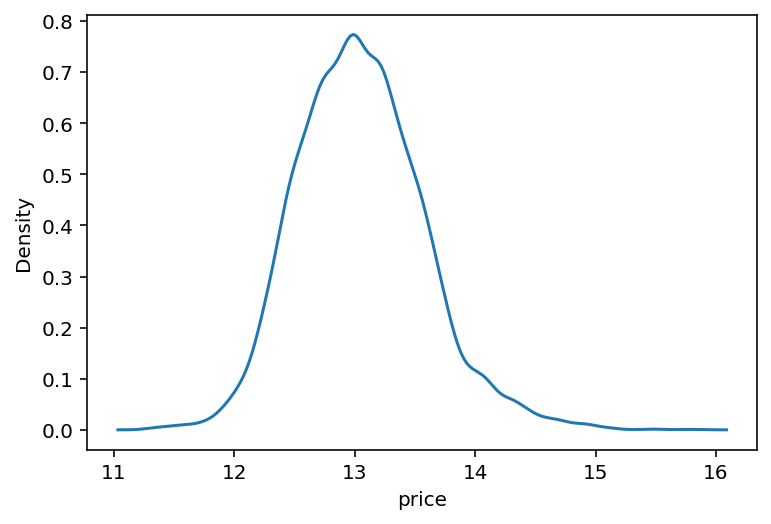

In [14]:
y_log_transformation = np.log1p(y)

sns.kdeplot(y_log_transformation)
plt.show()

학습 데이터와 테스트 데이터를 다시 나눔

In [15]:
sub = data.iloc[train_len:, :]
x = data.iloc[:train_len, :]

print(x.shape)
print(sub.shape)

(15035, 19)
(6468, 19)


price와 상관도가 높은 변수 10개를 살펴보기 위해 스피어만 순위 상관관계를 히트맵으로 표현   

- 피어슨 상관관계 : 연속형 변수에 사용
- 스피어만 순위 상관관계 : 범주형 변수도 포함되었을 경우에 사용


['price' 'grade' 'sqft_living' 'sqft_living15' 'sqft_above' 'bathrooms'
 'lat' 'bedrooms' 'floors' 'view']


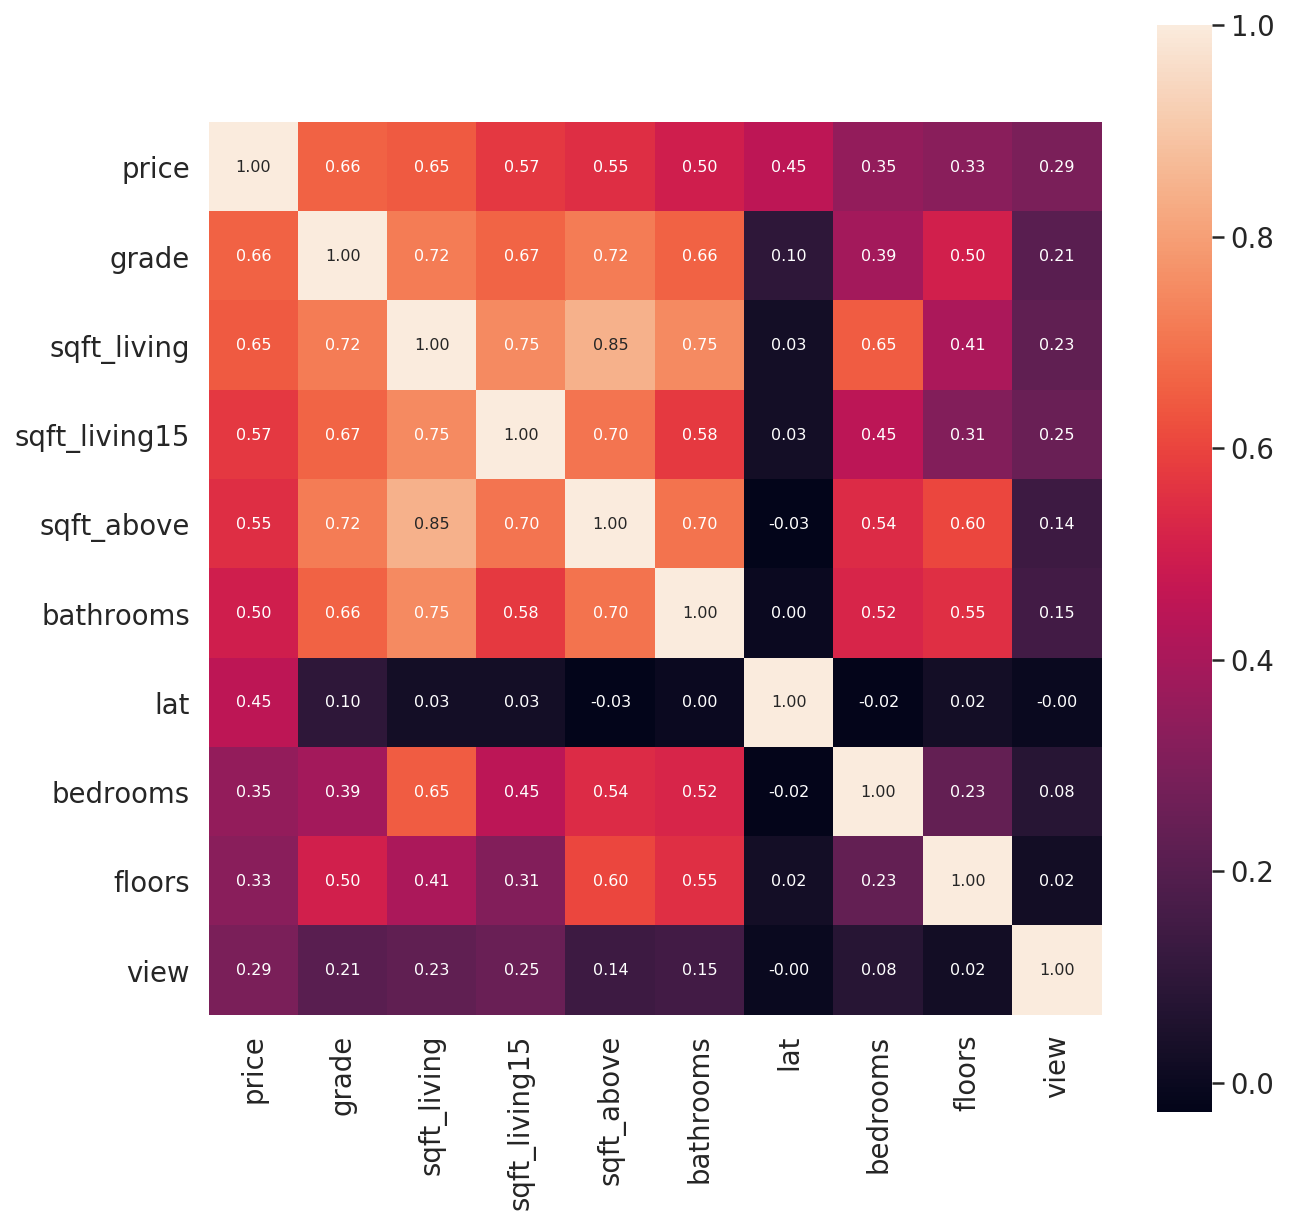

In [16]:
x['price'] = y_log_transformation

cor_abs = abs(x.corr(method='spearman')) 
cor_cols = cor_abs.nlargest(n=10, columns='price').index 

cor = np.array(sp.stats.spearmanr(x[cor_cols].values))[0] # 10 x 10
print(cor_cols.values)
plt.figure(figsize=(10,10))
sns.set(font_scale=1.25)
sns.heatmap(cor,
            fmt='.2f', 
            annot=True, 
            square=True, 
            annot_kws={'size' : 8},
            xticklabels=cor_cols.values, 
            yticklabels=cor_cols.values)

grade, sqft_living, sqft_living, sqft_living15 등의 값들이 price와 상관도가 높음을 확인할 수 있다.

**grade**

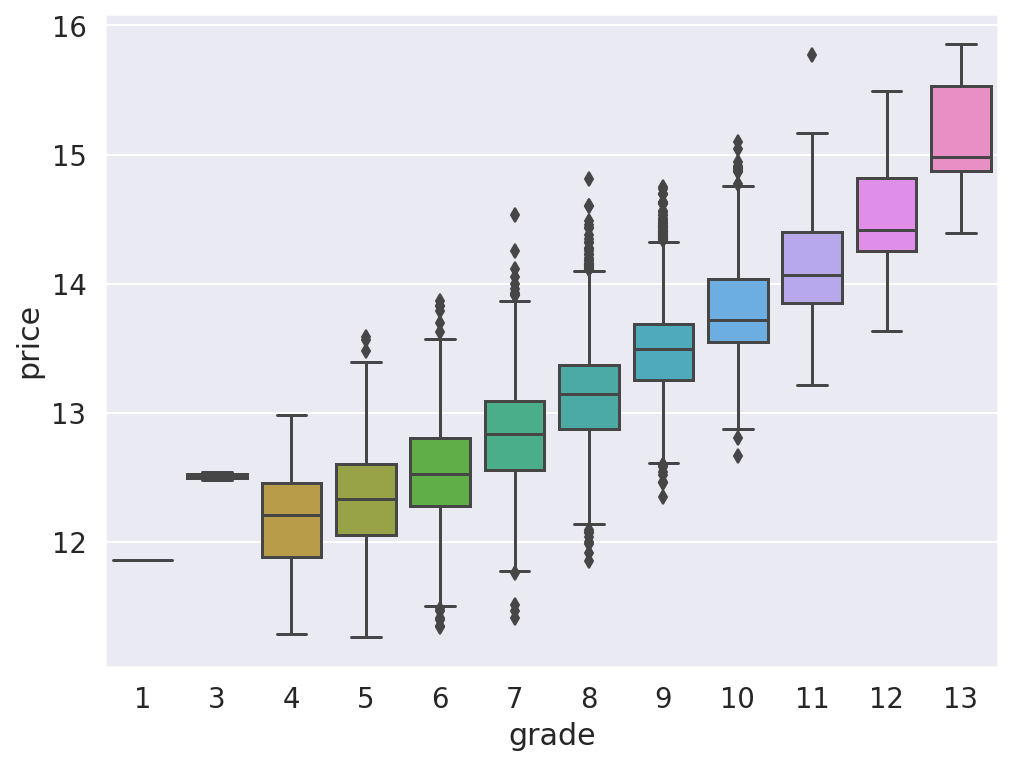

In [17]:
data = pd.concat([x['price'], x['grade']], axis=1)
f, ax = plt.subplots(figsize=(8, 6))
fig = sns.boxplot(x='grade', y='price', data=data)

당연하지만, 대체적으로 등급이 높아질수록 집 값이 올라가는 경향이 있다. 단, grade에 대해 더 살펴봐야 할 것은, 다음과 같다.
1. 3등급 집들이 보다 높은 4, 5등급의 집들보다 가격이 높은 이유
3. 7, 8, 11등급에서 차이가 큰 이상치가 발생한 이유

In [18]:
x[(x['grade'] == 3)].median()

date             201456.500000
bedrooms              0.693147
bathrooms             0.375000
sqft_living           6.327172
sqft_lot              9.788915
floors                1.000000
waterfront            0.000000
view                  0.000000
condition             3.500000
grade                 3.000000
sqft_above            6.327172
sqft_basement         0.000000
yr_built           1935.000000
yr_renovated          0.000000
zipcode           98033.500000
lat                  47.369900
long               -121.872000
sqft_living15      1165.000000
sqft_lot15        17391.000000
price                12.509326
dtype: float64

In [19]:
x[(x['grade'] == 4) | (x['grade']==5)].median()

date             201411.000000
bedrooms              1.098612
bathrooms             1.000000
sqft_living           6.734592
sqft_lot              8.853808
floors                1.000000
waterfront            0.000000
view                  0.000000
condition             3.000000
grade                 5.000000
sqft_above            6.710523
sqft_basement         0.000000
yr_built           1939.000000
yr_renovated          0.000000
zipcode           98059.000000
lat                  47.496500
long               -122.234000
sqft_living15      1340.000000
sqft_lot15         7405.000000
price                12.323860
dtype: float64

3등급인 집들이 4, 5등급의 집들보다 더 값이 높을 이유를 찾을 수 없으므로, 제거한다.

In [20]:
x = x.drop(x.loc[x['grade'] == 3].index)

In [21]:
x.loc[(x['grade'] == 7) & (x['price'] > 14.1)]

,date,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,view,condition,grade,sqft_above,sqft_basement,yr_built,yr_renovated,zipcode,lat,long,sqft_living15,sqft_lot15,price
8148,201504,1.609438,2.25,7.878913,8.006701,2.0,0,0,3,7,7.640604,6.329721,1908,0,98109,47.6313,-122.344,1910,3000,14.250535
12346,201501,1.609438,3.25,8.183397,9.902987,1.5,1,4,4,7,8.155075,4.615121,1915,1965,98125,47.7087,-122.276,2410,6389,14.533351
12457,201408,1.386294,2.00,7.635787,9.169623,1.0,0,1,3,7,7.372118,6.175867,1946,0,98039,47.6160,-122.239,3000,16215,14.115616


7등급짜리 집의 이상치처럼 보이는 값은 값이 높을 이유가 있으므로 그냥 둔다.

In [22]:
x.loc[(x['grade'] == 8) & (x['price']>14.6)]

,date,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,view,condition,grade,sqft_above,sqft_basement,yr_built,yr_renovated,zipcode,lat,long,sqft_living15,sqft_lot15,price
983,201505,1.791759,4.25,8.442685,10.030296,2.0,1,4,5,8,7.958926,7.484930,1952,0,98052,47.6393,-122.097,3140,14200,14.603968
7173,201408,1.791759,4.00,8.350194,10.214495,2.0,1,4,3,8,8.080547,6.908755,1949,1985,98033,47.6803,-122.214,2660,27295,14.808763
10037,201408,1.386294,2.00,8.180601,10.324071,1.0,0,1,3,8,7.635787,7.313887,1946,1982,98039,47.6413,-122.240,3570,27418,14.603968


8등급짜리 집의 이상치처럼 보이는 값은 값이 높을 이유가 없으므로 제거한다.

In [23]:
x = x.drop(x[(x['grade'] == 8) & (x['price'] >14.8)].index)

In [24]:
x[(x['grade'] == 11) & (x['price'] > 15.1)]

,date,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,view,condition,grade,sqft_above,sqft_basement,yr_built,yr_renovated,zipcode,lat,long,sqft_living15,sqft_lot15,price
1499,201411,1.609438,4.25,8.660601,9.966509,2.0,1,4,4,11,8.660601,0.000000,1980,0,98040,47.5850,-122.222,4620,22748,15.163584
2775,201406,1.791759,4.50,9.214432,10.527445,2.0,1,2,3,11,8.946505,7.766841,1940,2001,98004,47.6500,-122.214,3930,25449,15.770310
4598,201504,1.945910,4.75,8.609043,9.873131,1.5,1,4,5,11,8.271548,7.359468,1936,0,98105,47.6515,-122.277,3510,15810,15.110238
10645,201409,1.609438,3.25,8.482809,10.010457,2.0,1,4,4,11,8.482809,0.000000,1990,0,98039,47.6409,-122.241,3820,25582,15.107742


11등급짜리 집의 이상치처럼 보이는 값은 값이 높을 이유가 어느정도 보이므로 제거하지 않는다.

**sqft_living**

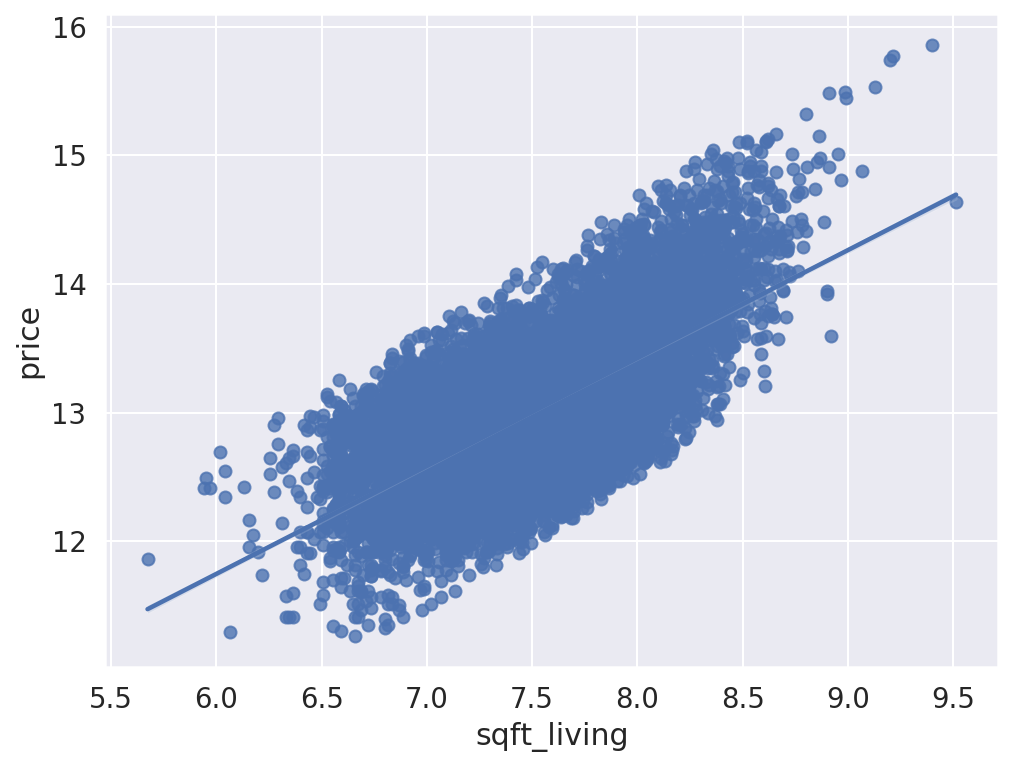

In [25]:
data = pd.concat([x['price'], x['sqft_living']], axis=1)
f, ax = plt.subplots(figsize=(8, 6))
fig = sns.regplot(x='sqft_living', y='price', data=data)

위에서 데이터의 분포를 정규분포화했기 때문에, 적절한 선형성을 보인다.

**sqft_living15**

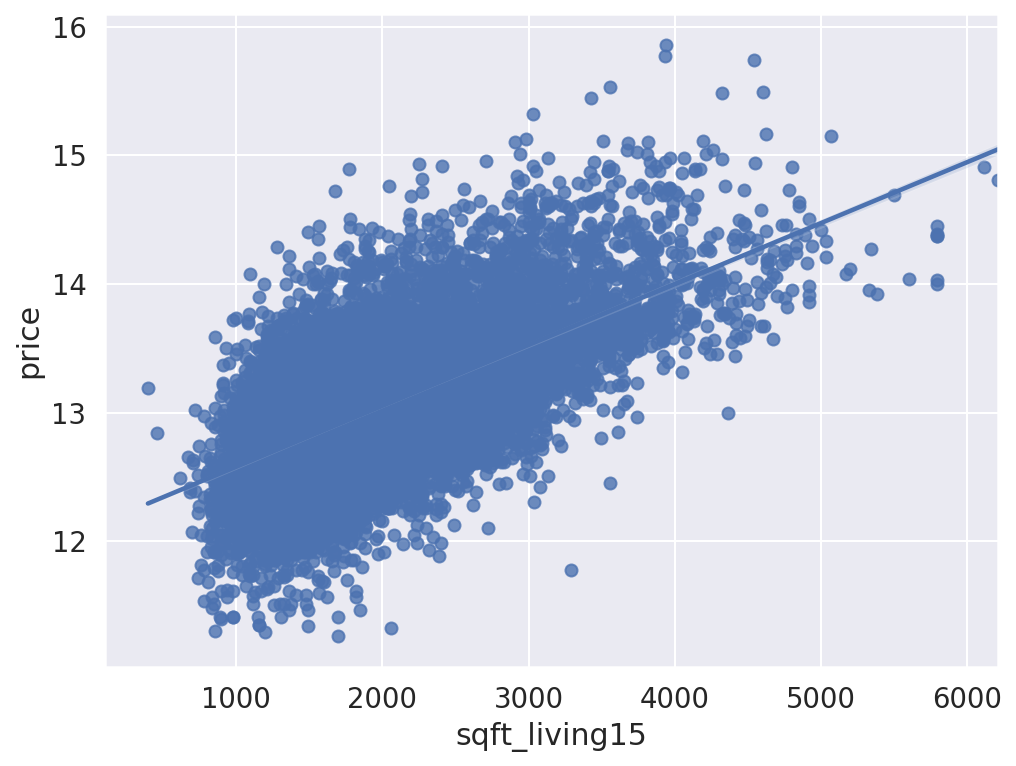

In [26]:
data = pd.concat([x['price'], x['sqft_living15']], axis=1)
f, ax = plt.subplots(figsize=(8,6))
fig = sns.regplot(x='sqft_living15', y='price', data=data)

sqft_living보다는 데이터의 분산이 큰 것을 확인할 수 있다.

**sqft_above**

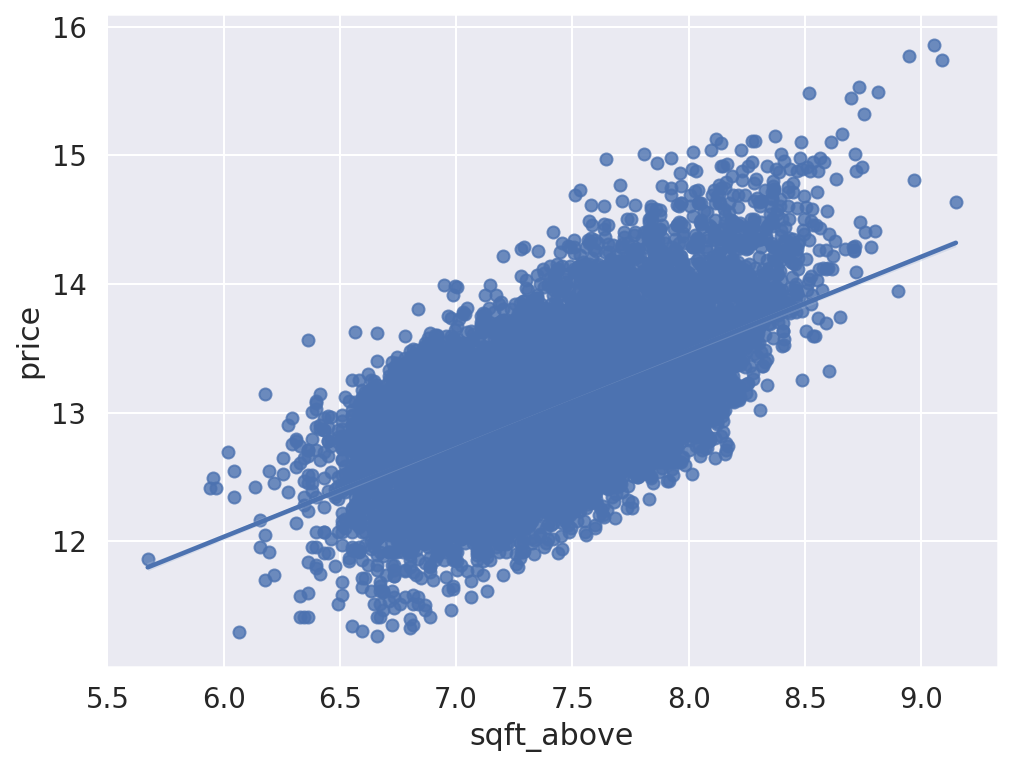

In [27]:
data = pd.concat([x['price'], x['sqft_above']], axis=1)
f, ax = plt.subplots(figsize=(8,6))
fig = sns.regplot(x='sqft_above', y='price', data=data)

sqft_living과 마찬가지로 위에서 정규분포화 했기 때문에 나름 적절한 선형성을 보이지만, sqft_above의 값이 커질수록 line과의 차이가 점점 커질 것으로 보인다.

**bathrooms**

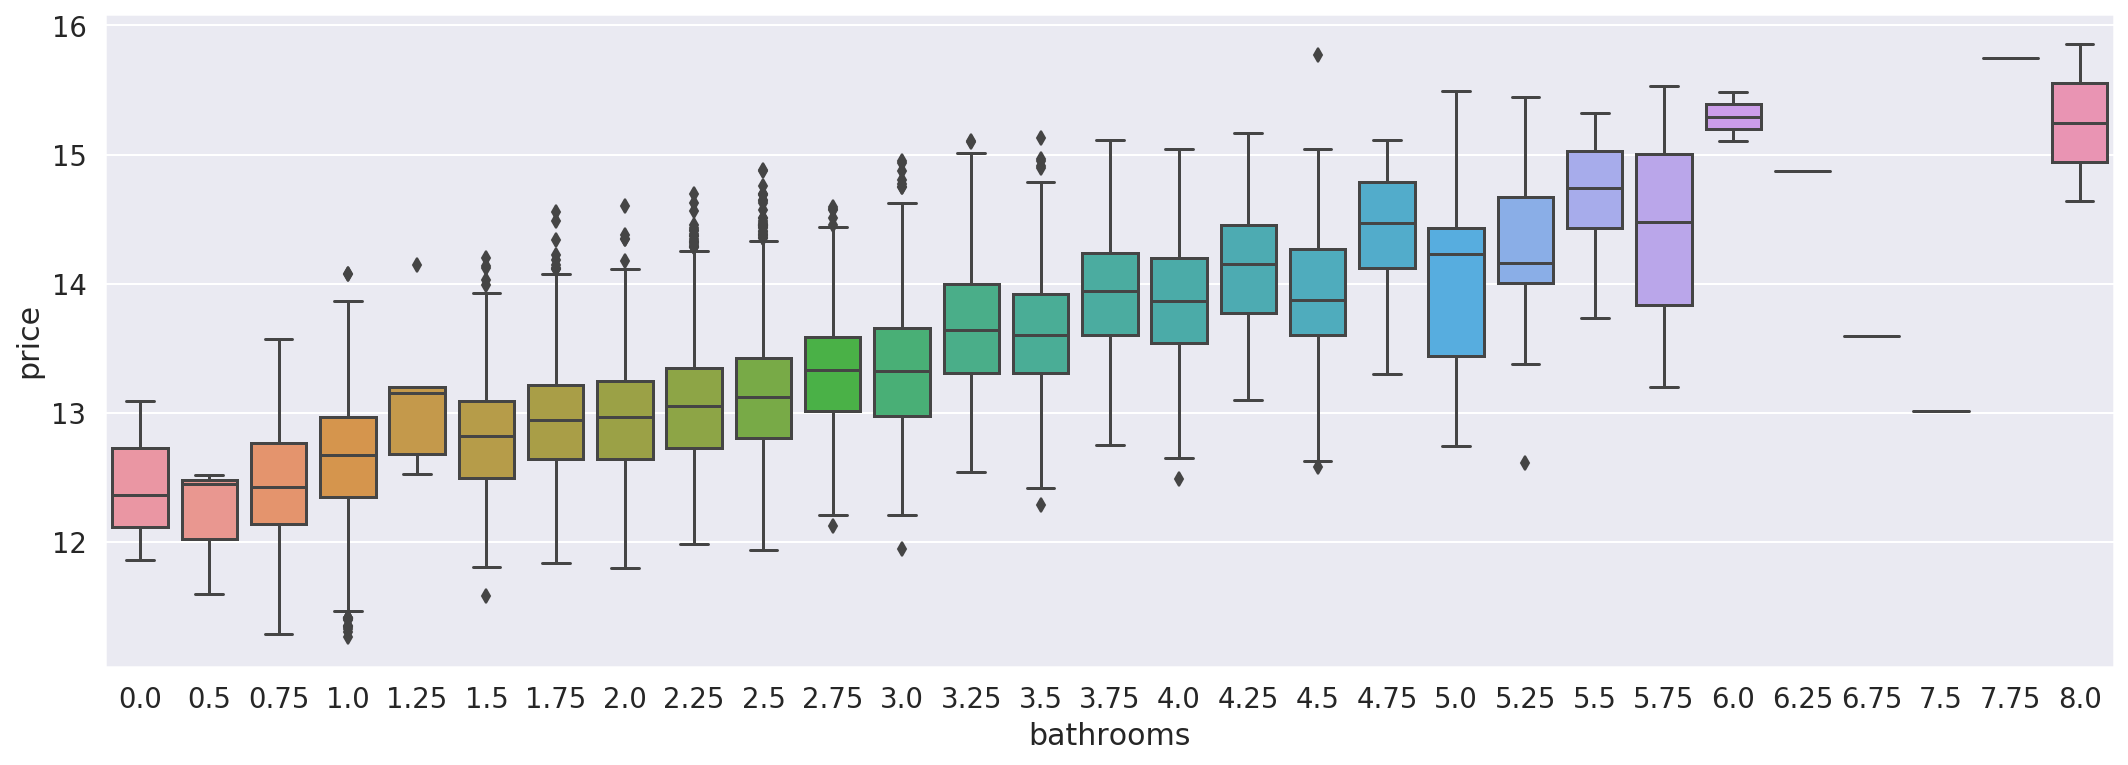

In [28]:
data = pd.concat([x['price'], x['bathrooms']], axis=1)
f, ax = plt.subplots(figsize=(18, 6))
fig = sns.boxplot(x='bathrooms', y='price', data=data)

전체적으로 보면 선형적이지만, 0.0 ~ 0.75까지는 중앙값이 거의 비슷하고, 1.25는 이상치로 보이는 데이터로 인해 중앙값이 상당히 높은 등의 유의할 점들이 있다.

**bedrooms**

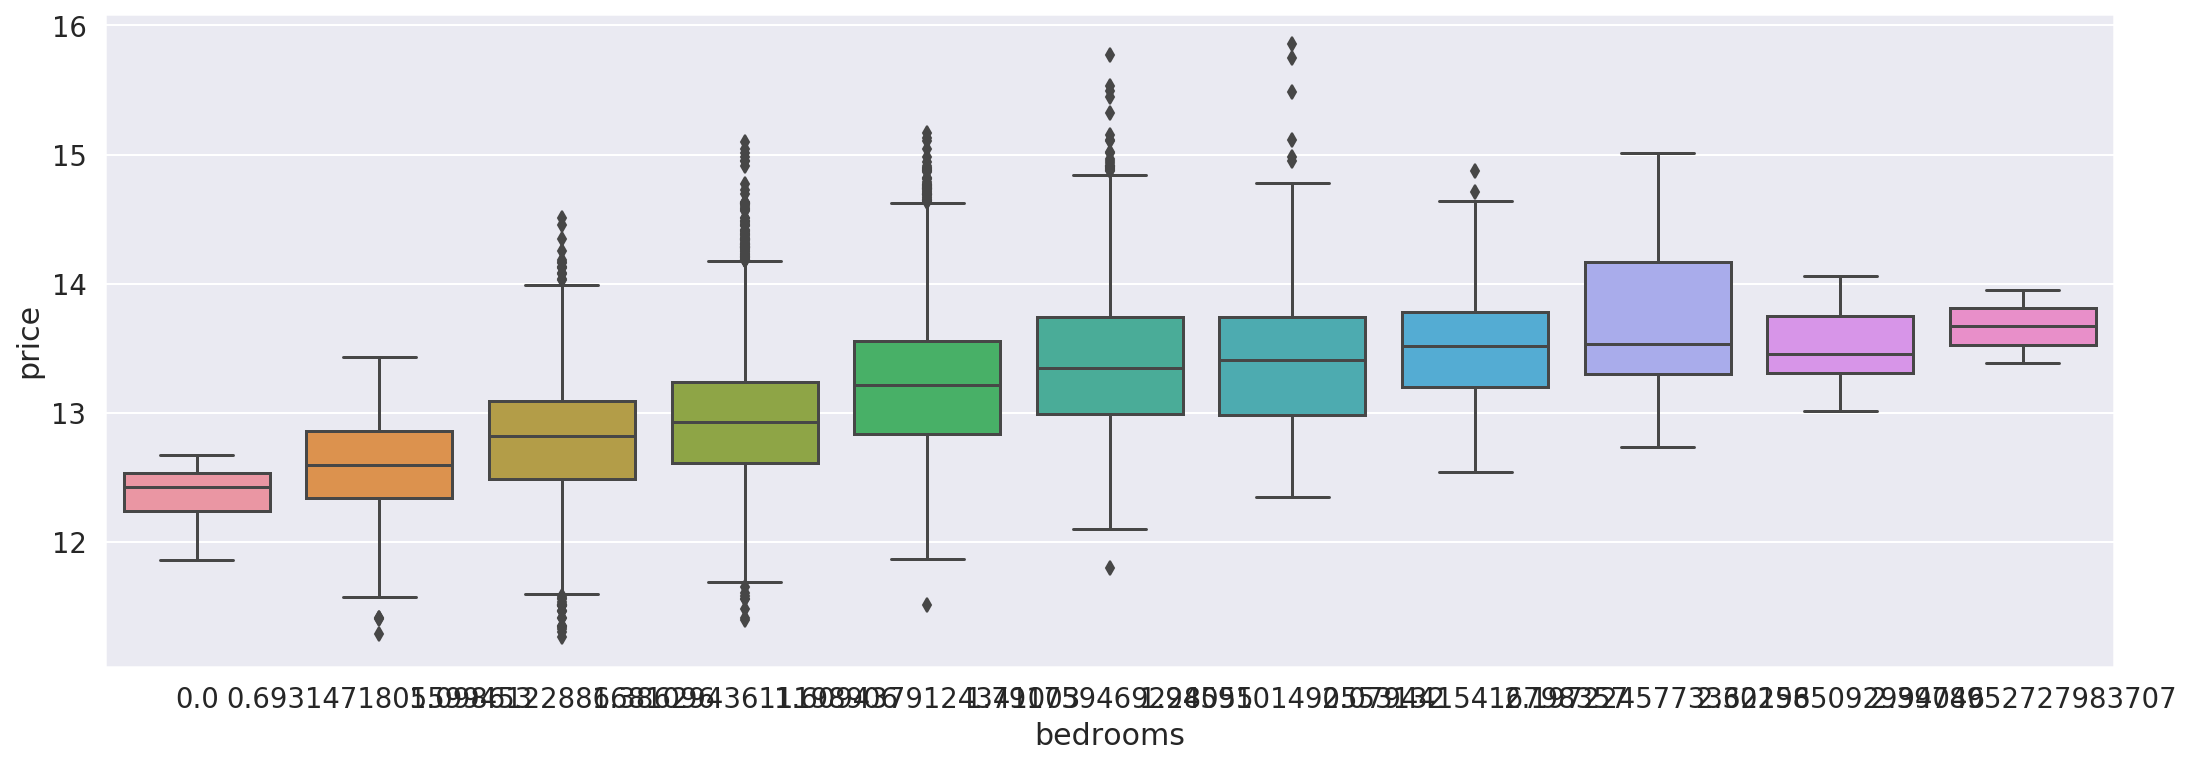

In [29]:
data = pd.concat([x['price'], x['bedrooms']], axis=1)
f, ax = plt.subplots(figsize=(18, 6))
fig = sns.boxplot(x='bedrooms', y="price", data=data)

정규분포화로 인해 bedrooms의 값이 직관적이지 않아졌지만, 어쨌든 침실의 수에 따른 가격 변화는 대체적으로 선형적이다.

In [30]:
for df in [x, sub]:
    df['yr_renovated'] = df['yr_renovated'].apply(lambda c: np.nan if c == 0 else c)
    df['yr_renovated'] = df['yr_renovated'].fillna(df['yr_built'])

재건축한 해가 0인 것은 말이 안되므로, 지어진 년도를 입력한다.

### 변수 추가

In [31]:
for df in [x, sub]:
    # 방의 전체 갯수 
    df['total_rooms'] = df['bedrooms'] + df['bathrooms']
    
    # 거실의 비율 
    df['sqft_ratio'] = df['sqft_living'] / df['sqft_lot']
    
    df['sqft_total_size'] = df['sqft_above'] + df['sqft_basement']
    
    # 면적 대비 거실의 비율 
    df['sqft_ratio_1'] = df['sqft_living'] / df['sqft_total_size']
    
    df['sqft_ratio15'] = df['sqft_living15'] / df['sqft_lot15'] 
    
    # 재건축 여부 
    df['is_renovated'] = df['yr_renovated'] - df['yr_built']
    df['is_renovated'] = df['is_renovated'].apply(lambda x: 0 if x == 0 else 1)
    df['date'] = df['date'].astype('int')

In [32]:
x['per_price'] = x['price']/x['sqft_total_size']
zipcode_price = x.groupby(['zipcode'])['per_price'].agg({'mean','var'}).reset_index()
x = pd.merge(x,zipcode_price,how='left',on='zipcode')
sub = pd.merge(sub,zipcode_price,how='left',on='zipcode')

for df in [x, sub]:
    df['zipcode_mean'] = df['mean'] * df['sqft_total_size']
    df['zipcode_var'] = df['var'] * df['sqft_total_size']
    del df['mean']; del df['var']

In [33]:
a = x[['zipcode', 'price']].groupby('zipcode').mean()
label = [j+1 for j in range(27)]
a['zip_level'] = pd.cut(a.price, bins=27, labels=label)
a = a.drop(['price'], axis=1)

x = x.merge(a, on='zipcode', how='left')
sub = sub.merge(a, on='zipcode', how='left')
x.zip_level = x.zip_level.astype(int)
sub.zip_level = sub.zip_level.astype(int)

In [34]:
y = x['price']
del x['price']
del x['per_price']

### 모델 설계 및 평가

RMSE를 계산하는 함수

In [35]:
def rmse(y_test, y_pred):
    return np.sqrt(mean_squared_error(np.expm1(y_test), np.expm1(y_pred)))

앙상블로 사용할 모델들에 대해 RMSE를 한 번에 계산하기 위한 함수

In [36]:
def get_scores(models, train, y):
    df = {}

    for model in models:
        model_name = model.__class__.__name__
        X_train, X_test, y_train, y_test = train_test_split(train, y, random_state=random_state, test_size=0.2)
        model.fit(X_train, y_train)
        y_pred = model.predict(X_test)
        df[model_name] = rmse(y_test, y_pred)
        score_df = pd.DataFrame(df, index=['RMSE']).T.sort_values('RMSE', ascending=False)

    return (score_df)

파라미터 튜닝을 위해 그리드 탐색을 하고 RMSLE 값이 낮은 순서대로 반환하는 함수

In [37]:
def do_GridSearch(model, train, y, param_grid, verbose=2, n_jobs=5):
    gs_model = GridSearchCV(model, 
                            param_grid=param_grid, 
                            scoring='neg_mean_squared_error',
                            cv=5,
                            verbose=verbose,
                            n_jobs=n_jobs)
    gs_model.fit(train, y)

    params = gs_model.cv_results_['params']
    score = gs_model.cv_results_['mean_test_score']

    results = pd.DataFrame(params)
    results['score'] = score
    results['RMSLE'] = np.sqrt(-1 * results['score'])
    results = results.sort_values('RMSLE')

    return results

제출 파일 저장을 위한 함수

In [38]:
def save_submission(model, train, y, test, model_name, rmsle):
    model.fit(train, y)
    y_pred = model.predict(test)
    y_pred = np.expm1(y_pred)

    data_dir = os.getenv('HOME')+'/aiffel/kaggle_kakr_housing/data'

    submission_path = join(data_dir, 'sample_submission.csv')
    submission = pd.read_csv(submission_path)

    submission['price'] = y_pred

    submission_csv_path = f'{data_dir}/submission_{model_name}_RMSE_{rmsle}.csv'
    submission.to_csv(submission_csv_path, index=False)

XGBRegressor, LGBMRegressor, GradientBoostingRegressor, RandomForestRegressor 네 가지 모델을 사용

In [39]:
random_state = 2020

In [42]:
model = LGBMRegressor(learning_rate=0.05, max_depth=40, n_estimators=1600, random_state=random_state, colsample_bytree=0.7)

In [44]:
model.fit(x, y)

[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).


LGBMRegressor(colsample_bytree=0.7, learning_rate=0.05, max_depth=40,
              n_estimators=1600, random_state=2020)

In [45]:
get_scores([model], x, y)

,RMSE
LGBMRegressor,112035.933882


In [46]:
save_submission(model, x, y, sub, "lightgbm", 112035)

[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).


### 회고

캐글 프로젝트부터 약간 답답함을 느끼고 있다.   
어떤 파라미터를 어떻게 조정하고 어떻게 데이터를 전처리해야 성능이 향상될지 예측하는 기준이 무엇인지 찾기 어려운게 주된 이유다.   
나름 데이터를 전처리했다고 생각하고 모델에 학습시켰는데 성능이 크게 향상되지 않았다.   
캐글에 올라온 잘 짜여진 코드들을 보고 왜 그렇게 코드를 짰는지를 중점으로 이해해가며 공부할 필요성을 느낀다.   
이번 프로젝트는 캐글에서 많은 추천을 받은 코드를 노드의 내용과 결합해봤지만, 결합 과정에서 성능을 저하시키는 요인이 발생한 것 같다.
캐글에 올라와있는 점수보다 이 코드의 점수가 더 안좋게 나왔다.   

file:///home/aiffel/score.png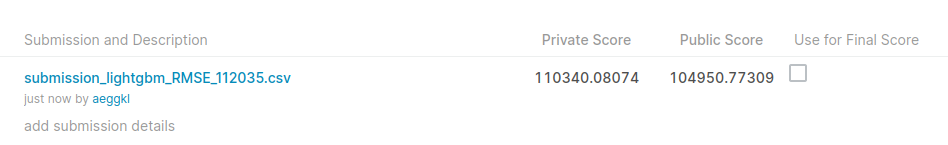